# Part 1: Support Vector Machines

In [1]:
import numpy as np
import pandas as pd
import cvxopt
from cvxopt import solvers,matrix
import math
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from csv import reader
from random import seed
from random import randrange

In [2]:
# Get CSV file
def get_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        data = reader(file)
        for row in data:
            if not row:
                continue
            dataset.append(row)
    return dataset

# String to float columnwise
def str_to_float_col(dataset, col):
    for row in dataset:
        row[col] = float(row[col].strip())
        
# form dataset from health data
filename = 'bc.csv'
dataset = get_csv(filename)
dataset.remove(dataset[0])
for i in range(len(dataset[0])):
    str_to_float_col(dataset, i)

#visualising dataset in form of a dataframe
df = pd.DataFrame(dataset)
df

0      1      2    3
0    26.0  109.0  243.0  0.0
1    27.0  106.0  156.0  0.0
2    28.0  107.0  225.0  0.0
3    27.0  105.0  277.0  0.0
4    30.0   96.0  221.0  0.0
..    ...    ...    ...  ...
695  47.0  111.0  202.0  1.0
696  58.0  145.0  236.0  1.0
697  46.0  121.0  219.0  1.0
698  43.0  119.0  239.0  1.0
699  42.0  132.0  251.0  1.0

[700 rows x 4 columns]

In [3]:
#data manipulation before training

def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

def shuffle_data(x, y, seed=None):
    if seed:
        np.random.seed(seed)
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    return x[idx], y[idx]

def train_test_split(x, y, test_size=0.2, shuffle=True, seed=None):
    if shuffle:
        x, y = shuffle_data(x, y, seed)
    split_i = len(y) - int(len(y) // (1 / test_size))
    x_train, x_test = x[:split_i], x[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return x_train, x_test, y_train, y_test

def k_fold_cross_validation_sets(x, y, k, shuffle=True):
    if shuffle:
        x, y = shuffle_data(x, y)

    n_samples = len(y)
    left_overs = {}
    n_left_overs = (n_samples % k)
    if n_left_overs != 0:
        left_overs["x"] = x[-n_left_overs:]
        left_overs["y"] = y[-n_left_overs:]
        x = x[:-n_left_overs]
        y = y[:-n_left_overs]

    x_split = np.split(x, k)
    y_split = np.split(y, k)
    sets = []
    for i in range(k):
        x_test, y_test = x_split[i], y_split[i]
        x_train = np.concatenate(x_split[:i] + x_split[i + 1:], axis=0)
        y_train = np.concatenate(y_split[:i] + y_split[i + 1:], axis=0)
        sets.append([x_train, x_test, y_train, y_test])

    if n_left_overs != 0:
        np.append(sets[-1][0], left_overs["x"], axis=0)
        np.append(sets[-1][2], left_overs["y"], axis=0)

    return np.array(sets)

def accuracy_score(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

In [4]:
#data preparation
dataset = np.asarray(dataset)
x_pre = dataset.T[:-1]
x_pre = x_pre.T
y = dataset.T[-1]
y = np.where((y == 0),-1.0,1.0)
x = normalize(x_pre)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

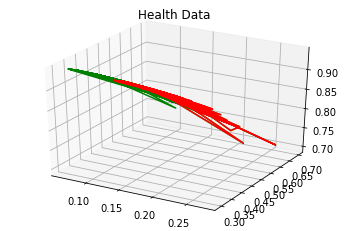

In [5]:
#data visualization 3D
X0,Y0,Z0 = [], [], []
X1,Y1,Z1 = [], [], []

for i in range(len(dataset)):
    if dataset.T[-1][i] == 0:
        X0.append(x.T[0][i])
        Y0.append(x.T[1][i])
        Z0.append(x.T[2][i])
    else:
        X1.append(x.T[0][i])
        Y1.append(x.T[1][i])
        Z1.append(x.T[2][i])
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot3D(X0, Y0, Z0, 'green')
ax.plot3D(X1, Y1, Z1, 'red')
ax.set_title('Health Data')

plt.show()

In [6]:
#kernels

def linear_kernel(**kwargs):
    def f(x1, x2):
        return np.inner(x1, x2) 
    return f

def polynomial_kernel(power, coef, **kwargs):
    def f(x1, x2):
        return (np.inner(x1, x2) + coef)**power
    return f

def gaussian_kernel(gamma=0.05, **kwargs):
    def f(x1, x2):
        distance = np.linalg.norm(x1 - x2) ** 2
        return np.exp(-gamma * distance)
    return f

## 1.1 SVM with Convex Optimization

In [7]:
class SVM(object):

    def __init__(self, C=1, kernel=gaussian_kernel, power=2, gamma=0.05, coef=4):
        self.C = C
        self.kernel = kernel
        self.power = power
        self.gamma = gamma
        self.coef = coef
        self.lagr_multipliers = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.intercept = None

    def fit(self, X, y):
        n_samples, n_features = np.shape(X)

        if not self.gamma:
            self.gamma = 1 / n_features

        self.kernel = self.kernel(power=self.power, gamma=self.gamma, coef=self.coef)

        kernel_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel_matrix[i, j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d')
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples), tc='d')
        b = cvxopt.matrix(0, tc='d')

        if not self.C:
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G_max = np.identity(n_samples) * -1
            G_min = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            h_max = cvxopt.matrix(np.zeros(n_samples))
            h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
            h = cvxopt.matrix(np.vstack((h_max, h_min)))
        
        cvxopt.solvers.options['show_progress'] = False
        minimization = cvxopt.solvers.qp(P, q, G, h, A, b)

        lagr_mult = np.ravel(minimization['x'])

        idx = lagr_mult > 1e-7
        self.lagr_multipliers = lagr_mult[idx]
        self.support_vectors = X[idx]
        self.support_vector_labels = y[idx]

        self.intercept = self.support_vector_labels[0]
        for i in range(len(self.lagr_multipliers)):
            self.intercept -= self.lagr_multipliers[i] * self.support_vector_labels[
                i] * self.kernel(self.support_vectors[i], self.support_vectors[0])

    def predict(self, X):
        y_pred = []
        for sample in X:
            prediction = 0
            for i in range(len(self.lagr_multipliers)):
                prediction += self.lagr_multipliers[i] * self.support_vector_labels[
                    i] * self.kernel(self.support_vectors[i], sample)
            prediction += self.intercept
            y_pred.append(np.sign(prediction))
        return np.array(y_pred)

In [8]:
classifier =  SVM(kernel=linear_kernel)
classifier.fit(x_train, y_train)
y_pred_l = classifier.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_l)

y_pred = classifier.predict(x_train)
train_accuracy = accuracy_score(y_train, y_pred)
print ("Train Accuracy:", train_accuracy)
print ("Test Accuracy:", test_accuracy)

Train Accuracy: 0.6666666666666666
Test Accuracy: 0.6


In [9]:
y_pred_p = []
for pwr in range(2,5):
    classifier =  SVM(kernel=polynomial_kernel, power=pwr)
    classifier.fit(x_train, y_train)
    y_pred_p.append(classifier.predict(x_test))
    test_accuracy = accuracy_score(y_test, y_pred_p[pwr-2])

    y_pred = classifier.predict(x_train)
    train_accuracy = accuracy_score(y_train, y_pred)
    print ("Degree "+ str(pwr)+" Train Accuracy:", train_accuracy)
    print ("Degree "+ str(pwr)+" Test Accuracy:", test_accuracy)

Degree 2 Train Accuracy: 0.4984126984126984
Degree 2 Test Accuracy: 0.6
Degree 3 Train Accuracy: 0.7507936507936508
Degree 3 Test Accuracy: 0.7571428571428571
Degree 4 Train Accuracy: 0.7666666666666667
Degree 4 Test Accuracy: 0.7714285714285715


In [19]:
#grid search for Gaussian
test_accuracy, train_accuracy = -1, -1
C_ans, gamma_ans = -1,-1
for C_check in np.arange(0.5,1.5,0.1):
    for gamma_check in np.arange(pow(10,-3),pow(10,-2),pow(10,-3)):
        classifier =  SVM(C=C_check,kernel=gaussian_kernel,gamma=gamma_check)
        classifier.fit(x_train, y_train)
        y_pred_g = classifier.predict(x_test)
        test_accuracy_sample = accuracy_score(y_test, y_pred_g)
        if (test_accuracy_sample>test_accuracy):
            test_accuracy=test_accuracy_sample
            C_ans, gamma_ans = C_check, gamma_check
            y_trpred_g = classifier.predict(x_train)
            train_accuracy = accuracy_score(y_train, y_trpred_g)
print ("Most optimal C value:", C_ans)
print ("Most optimal gamma value:", gamma_ans)
print ("Train Accuracy:", train_accuracy)
print ("Test Accuracy:", test_accuracy)

Most optimal C value: 0.5
Most optimal gamma value: 0.001
Train Accuracy: 0.7714285714285715
Test Accuracy: 0.7714285714285715


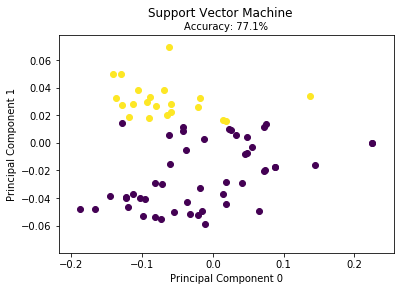

In [20]:
# Reduce dimension to two using PCA and plot the results
cmap = plt.get_cmap('viridis')

def calculate_covariance_matrix(X, Y=None):
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)

def transform(X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        X_transformed = X.dot(eigenvectors)

        return X_transformed

def plot_in_2d(X, y=None, title=None, accuracy=None, legend_labels=None):
    X_transformed = transform(X, dim=2)
    x1 = X_transformed[:, 0]
    x2 = X_transformed[:, 1]
    class_distr = []

    y = np.array(y).astype(int)

    colors = [cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

    # Plot the different class distributions
    for i, l in enumerate(np.unique(y)):
        _x1 = x1[y == l]
        _x2 = x2[y == l]
        _y = y[y == l]
        class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

    # Plot legend
    if not legend_labels is None: 
        plt.legend(class_distr, legend_labels, loc=1)

    # Plot title
    if title:
        if accuracy:
            perc = 100 * accuracy
            plt.suptitle(title)
            plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
        else:
            plt.title(title)

    # Axis labels
    plt.xlabel('Principal Component 0')
    plt.ylabel('Principal Component 1')

    plt.show()

plot_in_2d(x_test, y_pred_g, title="Support Vector Machine", accuracy=test_accuracy)

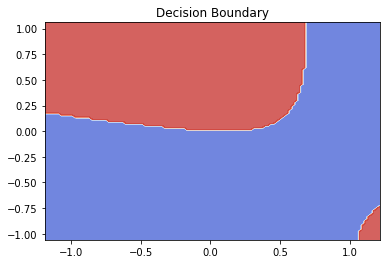

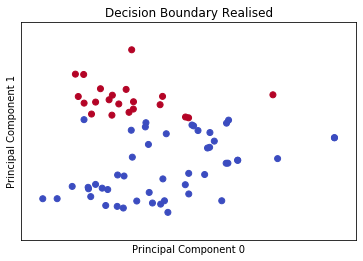

In [36]:
def flattener(X, y=None, title=None, accuracy=None, legend_labels=None):
    X_transformed = transform(X, dim=2)
    x1 = X_transformed[:, 0]
    x2 = X_transformed[:, 1]
    class_distr = []

    y = np.array(y).astype(int)

    colors = [cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

#     # Plot the different class distributions
#     for i, l in enumerate(np.unique(y)):
#         _x1 = x1[y == l]
#         _x2 = x2[y == l]
#         _y = y[y == l]
# #         class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))
    return x1, x2

x1, x2 = flattener(x_test, y_pred_g)

x_min, x_max = x1.min() - 1, x1.max() + 1
y_min, y_max = x2.min() - 1, x2.max() + 1
h = 0.02
xx, yy= np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

x_t, y_t = flattener(x_train, y_train)
# print(x_t.shape)
# print(y_t.shape)

clf_p =  SVM(kernel=polynomial_kernel, power=4.7)
clf_p.fit(np.c_[x_t.ravel(), y_t.ravel()], y_train)
Z = clf_p.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plot_db1 = plt.figure(1)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.title("Decision Boundary")

plot_db = plt.figure(2)
plt.scatter(x1, x2, c=y_pred_g, cmap=plt.cm.coolwarm)
plt.title('Decision Boundary Realised')
plt.xlabel('Principal Component 0')
plt.ylabel('Principal Component 1')
plt.xticks(())
plt.yticks(())
plt.show()

## 1.2 SVM with self-written SMO

In [38]:
class SVM_SMO():

    def __init__(self, max_iter=10000, kernel_type='gaussian', C=0.5, epsilon=0.001, gamma=0.001):
        self.kernels = {'linear' : self.kernel_linear, 'quadratic' : self.kernel_quadratic, 'gaussian' : self.kernel_gaussian}
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.epsilon = epsilon
        self.gamma = gamma
    def fit(self, X, y):
        # Initialization
        n, d = X.shape[0], X.shape[1]
        alpha = np.zeros((n))
        kernel = self.kernels[self.kernel_type]
        count = 0
        while True:
            count += 1
            alpha_prev = np.copy(alpha)
            for j in range(0, n):
                i = self.get_rnd_int(0, n-1, j) # Get random int i~=j
                x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                if k_ij == 0:
                    continue
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                # Set new alpha values
                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])

            # Check convergence
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break

            if count >= self.max_iter:
                print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
                return
        # Compute final model parameters
        self.b = self.calc_b(X, y, self.w)
        if self.kernel_type == 'linear':
            self.w = self.calc_w(alpha, y, X)
        # Get support vectors
        alpha_idx = np.where(alpha > 0)[0]
        support_vectors = X[alpha_idx, :]
        return support_vectors, count
    def predict(self, X):
        return self.h(X, self.w, self.b)
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    def calc_w(self, alpha, y, X):
        return np.dot(X.T, np.multiply(alpha,y))
    # Prediction
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)
    # Prediction error
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
    def get_rnd_int(self, a,b,z):
        i = z
        cnt=0
        while i == z and cnt<1000:
            i = rnd.randint(a,b)
            cnt=cnt+1
        return i
    # Define kernels
    def kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)
    def kernel_quadratic(self, x1, x2):
        return (np.dot(x1, x2.T) ** 2)
    def kernel_gaussian(self, x1, x2, gamma=0.001):
        distance = np.linalg.norm(x1 - x2) ** 2
        return np.exp(-gamma*(distance))

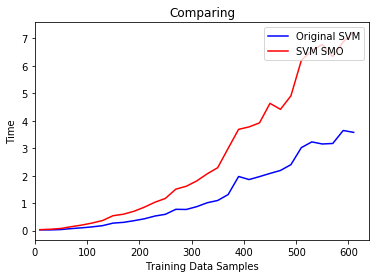

In [43]:
my_time = []
smo_time = []
for i in np.arange(10,630,20):
    x_, y_ = x_train[:i], y_train[:i]
    start = time.time()
    clf_my = SVM(C=0.5,kernel=gaussian_kernel,gamma=0.001).fit(x_, y_)
    my_time.append(time.time()-start)
    start - time.time()
    clf_smo = SVM().fit(x_, y_)
    smo_time.append(time.time()-start)
    
plot_compare = plt.figure(3)
plt.plot(np.arange(10,630,20), my_time, 'b', label="Original SVM")
plt.plot(np.arange(10,630,20), smo_time, 'r', label="SVM SMO")
plt.xlabel("Training Data Samples")
plt.ylabel("Time")
plt.title("Comparing")
plt.xlim(0,640)
plt.legend(loc="upper right")